In [23]:
%pip install -U tensorflow-addons  --quiet
%pip install numpy tensorflow --quiet
%pip install pillow --quiet
%pip install matplotlib --quiet
%pip install opencv-python scikit-learn --quiet
print("installation complete")


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
installation complete


In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split


c:\Users\soham\Desktop\CODE\Research\AutismDetectionUsingFacialImages\venv\Lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
num_classes = 2
input_shape = (32, 32, 3)

In [3]:
def load_images_from_folder(folder):
    images = []
    labels = []
    for class_label in os.listdir(folder):
        class_folder = os.path.join(folder, class_label)
        if not os.path.isdir(class_folder):
            continue
        for filename in os.listdir(class_folder):
            img_path = os.path.join(class_folder, filename)
            if os.path.isfile(img_path):
                image = cv2.imread(img_path)
                image = cv2.resize(image, (input_shape[1], input_shape[0]))
                images.append(image)
                labels.append(class_label)
                # Print the loaded image
                print(f"Loaded image: {img_path}")
    return np.array(images), np.array(labels).reshape(-1, 1)

train_folder = "dataset/dataset/train"
test_folder = "dataset/dataset/test"

x_train, y_train = load_images_from_folder(train_folder)
x_test, y_test = load_images_from_folder(test_folder)

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")


Loaded image: dataset/dataset/train\autistic\0001.jpg
Loaded image: dataset/dataset/train\autistic\0002.jpg
Loaded image: dataset/dataset/train\autistic\0003.jpg
Loaded image: dataset/dataset/train\autistic\0004.jpg
Loaded image: dataset/dataset/train\autistic\0005.jpg
Loaded image: dataset/dataset/train\autistic\0006.jpg
Loaded image: dataset/dataset/train\autistic\0007.jpg
Loaded image: dataset/dataset/train\autistic\0008.jpg
Loaded image: dataset/dataset/train\autistic\0009.jpg
Loaded image: dataset/dataset/train\autistic\0010.jpg
Loaded image: dataset/dataset/train\autistic\0011.jpg
Loaded image: dataset/dataset/train\autistic\0012.jpg
Loaded image: dataset/dataset/train\autistic\0013.jpg
Loaded image: dataset/dataset/train\autistic\0014.jpg
Loaded image: dataset/dataset/train\autistic\0015.jpg
Loaded image: dataset/dataset/train\autistic\0016.jpg
Loaded image: dataset/dataset/train\autistic\0017.jpg
Loaded image: dataset/dataset/train\autistic\0018.jpg
Loaded image: dataset/datase

In [4]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [5]:
# Data augmentation
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.Normalization(),
        layers.experimental.preprocessing.Resizing(input_shape[0], input_shape[1]),
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(factor=0.02),
        layers.experimental.preprocessing.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)

# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

In [6]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


In [7]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches


Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108
Patch 1:
tf.Tensor(
[174.       183.       188.       172.16667  181.5      186.33333
 167.27777  177.5      181.88889  162.88889  173.38889  177.27777
 162.       168.5      171.5      161.11111  163.61111  165.72223
 170.83333  179.83333  185.16667  169.08334  178.36111  183.5
 164.41666  174.43518  179.05556  159.65741  169.71295  173.6574
 154.25     159.41667  161.58333  148.84259  149.12038  149.50926
 162.38889  171.38889  177.61111  160.86111  169.99074  175.94444
 156.78703  166.26234  171.5      151.04012  159.91049  164.00308
 133.58333  135.19444  135.13889  116.12654  110.47839  106.27469
 154.94444  164.05556  171.05556  153.66667  162.74075  169.43518
 150.25926  159.23457  165.1142   143.81172  151.53395  155.91667
 116.083336 114.47222  112.583336  88.354935  77.4105    69.25001
 154.5      164.5      171.5      153.66667  163.33334  170.25
 151.44444  160.22223  166.91666  146.30556  

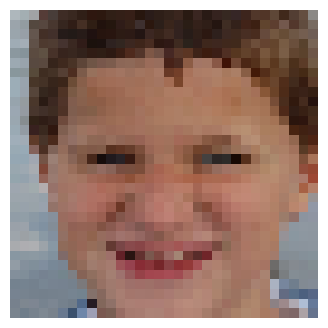

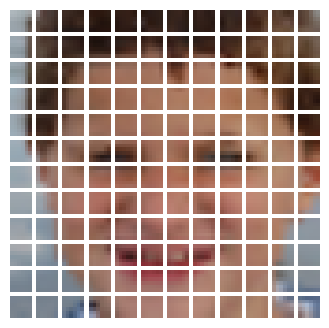

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")
    # Print the patch
    print(f"Patch {i+1}:")
    print(patch)


In [15]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

# Create an instance of PatchEncoder
num_patches = 16
projection_dim = 64
patch_encoder = PatchEncoder(num_patches, projection_dim)

# Test the PatchEncoder
random_patch = tf.random.normal((1, num_patches, projection_dim))
encoded_patch = patch_encoder(random_patch)
print("Encoded Patch Shape:", encoded_patch.shape)
print("Encoded Patch:")
print(encoded_patch)


Encoded Patch Shape: (1, 16, 64)
Encoded Patch:
tf.Tensor(
[[[ 1.3195089   0.27251127 -1.7614202  ...  0.1870378   0.35595268
   -0.77730715]
  [ 0.81875527 -0.8894107   0.04920306 ...  1.1267699   1.1707258
   -1.2549193 ]
  [ 0.331096    0.57239807  0.06704095 ...  0.87210584 -0.6355395
    0.41078156]
  ...
  [ 0.13330647 -0.28971326  1.4386282  ...  0.38058093 -1.5784639
    1.3925853 ]
  [ 0.27814052  0.00408467  1.5606813  ... -0.07681035  0.9646965
   -0.8876478 ]
  [-2.1807714   1.031869    1.1807888  ...  1.5343614  -0.39971867
    1.6740588 ]]], shape=(1, 16, 64), dtype=float32)


In [16]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.GlobalAveragePooling1D()(representation)  # Change from Flatten() to GlobalAveragePooling1D()
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model


In [19]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_data=(x_test, y_test),
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)


Epoch 1/100


UnimplementedError: Graph execution error:

Detected at node 'Cast_1' defined at (most recent call last):
    File "<frozen runpy>", line 198, in _run_module_as_main
    File "<frozen runpy>", line 88, in _run_code
    File "c:\Users\soham\Desktop\CODE\Research\AutismDetectionUsingFacialImages\venv\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\soham\Desktop\CODE\Research\AutismDetectionUsingFacialImages\venv\Lib\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "c:\Users\soham\Desktop\CODE\Research\AutismDetectionUsingFacialImages\venv\Lib\site-packages\ipykernel\kernelapp.py", line 728, in start
      self.io_loop.start()
    File "c:\Users\soham\Desktop\CODE\Research\AutismDetectionUsingFacialImages\venv\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "C:\Python311\Lib\asyncio\base_events.py", line 607, in run_forever
      self._run_once()
    File "C:\Python311\Lib\asyncio\base_events.py", line 1922, in _run_once
      handle._run()
    File "C:\Python311\Lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\soham\Desktop\CODE\Research\AutismDetectionUsingFacialImages\venv\Lib\site-packages\ipykernel\kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "c:\Users\soham\Desktop\CODE\Research\AutismDetectionUsingFacialImages\venv\Lib\site-packages\ipykernel\kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "c:\Users\soham\Desktop\CODE\Research\AutismDetectionUsingFacialImages\venv\Lib\site-packages\ipykernel\kernelbase.py", line 409, in dispatch_shell
      await result
    File "c:\Users\soham\Desktop\CODE\Research\AutismDetectionUsingFacialImages\venv\Lib\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "c:\Users\soham\Desktop\CODE\Research\AutismDetectionUsingFacialImages\venv\Lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "c:\Users\soham\Desktop\CODE\Research\AutismDetectionUsingFacialImages\venv\Lib\site-packages\ipykernel\zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\soham\Desktop\CODE\Research\AutismDetectionUsingFacialImages\venv\Lib\site-packages\IPython\core\interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "c:\Users\soham\Desktop\CODE\Research\AutismDetectionUsingFacialImages\venv\Lib\site-packages\IPython\core\interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "c:\Users\soham\Desktop\CODE\Research\AutismDetectionUsingFacialImages\venv\Lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\soham\Desktop\CODE\Research\AutismDetectionUsingFacialImages\venv\Lib\site-packages\IPython\core\interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\soham\Desktop\CODE\Research\AutismDetectionUsingFacialImages\venv\Lib\site-packages\IPython\core\interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\soham\Desktop\CODE\Research\AutismDetectionUsingFacialImages\venv\Lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\soham\AppData\Local\Temp\ipykernel_256\563679826.py", line 41, in <module>
      history = run_experiment(vit_classifier)
    File "C:\Users\soham\AppData\Local\Temp\ipykernel_256\563679826.py", line 23, in run_experiment
      history = model.fit(
    File "c:\Users\soham\Desktop\CODE\Research\AutismDetectionUsingFacialImages\venv\Lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\soham\Desktop\CODE\Research\AutismDetectionUsingFacialImages\venv\Lib\site-packages\keras\engine\training.py", line 1685, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\soham\Desktop\CODE\Research\AutismDetectionUsingFacialImages\venv\Lib\site-packages\keras\engine\training.py", line 1284, in train_function
      return step_function(self, iterator)
    File "c:\Users\soham\Desktop\CODE\Research\AutismDetectionUsingFacialImages\venv\Lib\site-packages\keras\engine\training.py", line 1268, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\soham\Desktop\CODE\Research\AutismDetectionUsingFacialImages\venv\Lib\site-packages\keras\engine\training.py", line 1249, in run_step
      outputs = model.train_step(data)
    File "c:\Users\soham\Desktop\CODE\Research\AutismDetectionUsingFacialImages\venv\Lib\site-packages\keras\engine\training.py", line 1055, in train_step
      return self.compute_metrics(x, y, y_pred, sample_weight)
    File "c:\Users\soham\Desktop\CODE\Research\AutismDetectionUsingFacialImages\venv\Lib\site-packages\keras\engine\training.py", line 1149, in compute_metrics
      self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "c:\Users\soham\Desktop\CODE\Research\AutismDetectionUsingFacialImages\venv\Lib\site-packages\keras\engine\compile_utils.py", line 605, in update_state
      metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "c:\Users\soham\Desktop\CODE\Research\AutismDetectionUsingFacialImages\venv\Lib\site-packages\keras\utils\metrics_utils.py", line 77, in decorated
      update_op = update_state_fn(*args, **kwargs)
    File "c:\Users\soham\Desktop\CODE\Research\AutismDetectionUsingFacialImages\venv\Lib\site-packages\keras\metrics\base_metric.py", line 140, in update_state_fn
      return ag_update_state(*args, **kwargs)
    File "c:\Users\soham\Desktop\CODE\Research\AutismDetectionUsingFacialImages\venv\Lib\site-packages\keras\metrics\base_metric.py", line 676, in update_state
      y_true = tf.cast(y_true, self._dtype)
Node: 'Cast_1'
Cast string to float is not supported
	 [[{{node Cast_1}}]] [Op:__inference_train_function_28219]

In [2]:
num_classes = 2

In [3]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Dataset directory paths
train_dir = 'dataset/dataset/train/'
test_dir = 'dataset/dataset/test/'

# Image dimensions
image_size = (224, 224)
input_shape = (224, 224, 3)

# Define the DenseNet201 model
def create_densenet_model():
    base_model = DenseNet201(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape,
        pooling='avg'
    )

    # Add classification layer on top
    outputs = keras.layers.Dense(num_classes, activation='softmax')(base_model.output)

    # Create the model
    model = keras.Model(inputs=base_model.input, outputs=outputs)
    return model

# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator()

# Create train and test generators
batch_size = 32
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Create the DenseNet201 model
model = create_densenet_model()

# Compile the model
learning_rate = 1e-3
weight_decay = 0.0001
optimizer = tfa.optimizers.AdamW(
    learning_rate=learning_rate,
    weight_decay=weight_decay
)

model.compile(
    optimizer=optimizer,
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

# Training configuration
epochs = 35

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // batch_size,
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=test_generator.n // batch_size
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test loss: {test_loss:.4f}')
print(f'Test accuracy: {test_accuracy:.4f}')

# Plot accuracy and loss curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Predict classes for the test set
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
class_names = list(train_generator.class_indices.keys())
y_true = test_generator.classes

# Generate confusion matrix
confusion = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 8))
plt.imshow(confusion, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
ticks = np.arange(len(class_names))
plt.xticks(ticks, class_names, rotation=45)
plt.yticks(ticks, class_names)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

# Generate classification report
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)


Found 2526 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Epoch 1/35
 9/78 [==>...........................] - ETA: 1:29:13 - loss: 0.8610 - accuracy: 0.6424

KeyboardInterrupt: 

In [3]:
def load_image(image_path):
    img = Image.open(image_path)
    img = img.resize((224, 224))  # Resize the image to desired dimensions
    img = np.array(img) / 255.0  # Normalize the pixel values between 0 and 1
    if len(img.shape) < 3:
        # Convert grayscale image to RGB format
        img = np.stack((img,) * 3, axis=-1)
    return img


In [ ]:
import os
import numpy as np

# Define the directory paths
train_dir = 'dataset/dataset/train'
validation_dir = 'dataset/dataset/val'
test_dir = 'dataset/dataset/test'
input_shape = (224, 224, 3)


# Define a function to load the image
def load_image(image_path):
    # Load the image using any image processing library (e.g., PIL)
    image = Image.open(image_path)
    # Resize the image to the desired input shape
    image = image.resize(input_shape[:2])
    # Convert the image to numpy array
    image = np.array(image)
    # Normalize the image pixels to the range [0, 1]
    image = image / 224.0
    return image

# Load the train set
train_data = []
train_labels = []

train_autistic_dir = os.path.join(train_dir, 'autistic')
train_non_autistic_dir = os.path.join(train_dir, 'non_autistic')

# Load images from the 'autistic' class
for image_name in os.listdir(train_autistic_dir):
    image_path = os.path.join(train_autistic_dir, image_name)
    image = load_image(image_path)
    train_data.append(image)
    train_labels.append(0)  # Assign label 0 for 'autistic'

# Load images from the 'non_autistic' class
for image_name in os.listdir(train_non_autistic_dir):
    image_path = os.path.join(train_non_autistic_dir, image_name)
    image = load_image(image_path)
    train_data.append(image)
    train_labels.append(1)  # Assign label 1 for 'non_autistic'

x_train = np.array(train_data)
y_train = np.array(train_labels)

# Load the validation set
validation_data = []
validation_labels = []

validation_autistic_dir = os.path.join(validation_dir, 'autistic')
validation_non_autistic_dir = os.path.join(validation_dir, 'non_autistic')

# Load images from the 'autistic' class
for image_name in os.listdir(validation_autistic_dir):
    image_path = os.path.join(validation_autistic_dir, image_name)
    image = load_image(image_path)
    validation_data.append(image)
    validation_labels.append(0)  # Assign label 0 for 'autistic'

# Load images from the 'non_autistic' class
for image_name in os.listdir(validation_non_autistic_dir):
    image_path = os.path.join(validation_non_autistic_dir, image_name)
    image = load_image(image_path)
    validation_data.append(image)
    validation_labels.append(1)  # Assign label 1 for 'non_autistic'

x_val = np.array(validation_data)
y_val = np.array(validation_labels)

# Load the test set
test_data = []
test_labels = []

test_autistic_dir = os.path.join(test_dir, 'autistic')
test_non_autistic_dir = os.path.join(test_dir, 'non_autistic')

# Load images from the 'autistic' class
for image_name in os.listdir(test_autistic_dir):
    image_path = os.path.join(test_autistic_dir, image_name)
    image = load_image(image_path)
    test_data.append(image)
    test_labels.append(0)  # Assign label 0 for 'autistic'

# Load images from the 'non_autistic' class
for image_name in os.listdir(test_non_autistic_dir):
    image_path = os.path.join(test_non_autistic_dir, image_name)
    image = load_image(image_path)
    test_data.append(image)
    test_labels.append(1)  # Assign label 1 for 'non_autistic'

x_test = np.array(test_data)
y_test = np.array(test_labels)

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape} - y_val shape: {y_val.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

# Print a batch of images
batch_size = 5
indices = np.random.choice(range(x_train.shape[0]), size=batch_size, replace=False)
batch_images = x_train[indices]
batch_labels = y_train[indices]

for i in range(batch_size):
    image = batch_images[i]
    label = batch_labels[i]
    plt.imshow(image)
    plt.title(f"Label: {label}")
    plt.axis("off")
    plt.show()
